In [1]:
# ===============================================================================
# WEARABLE STRESS DETECTION DATASET PROCESSING
# ===============================================================================
"""
Processing comprehensive wearable device dataset for stress detection.
This notebook processes physiological data from wearable devices across three
categories: AEROBIC, ANAEROBIC, and STRESS conditions.

Sensor modalities: ACC (3-axis), BVP, EDA, HR, TEMP, IBI
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
from tqdm import tqdm
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("WEARABLE STRESS DETECTION DATASET PROCESSING")
print("=" * 60)

# Configuration
BASE_PATH = Path('/home/alvaro-ibarra/smartwatch-stress-detection')

# Output directory structure
OUTPUT_DIRS = {
    'processed': BASE_PATH / 'data' / 'processed',
    'results': BASE_PATH / 'results',
    'figures': BASE_PATH / 'data' / 'figures' / 'nb_03_wearable_processing',
    'models': BASE_PATH / 'models'
}

# Create directories
for name, path in OUTPUT_DIRS.items():
    path.mkdir(parents=True, exist_ok=True)
    print(f"  {name.capitalize()}: {path}")

# Key paths
PROCESSED_PATH = OUTPUT_DIRS['processed']
RESULTS_PATH = OUTPUT_DIRS['results']
FIGURES_PATH = OUTPUT_DIRS['figures']
MODELS_PATH = OUTPUT_DIRS['models']

# Dataset paths
DATA_PATH = BASE_PATH / 'data'
WEARABLE_DATASET_PATH = DATA_PATH / 'datasets' / 'wearable_device'
WEARABLE_RAW_PATH = WEARABLE_DATASET_PATH / 'raw'

# Verify paths
if not WEARABLE_RAW_PATH.exists():
    # Try alternative paths
    alternative_paths = [
        DATA_PATH / 'wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.1',
        DATA_PATH / 'datasets' / 'wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.1',
        BASE_PATH / 'data (Copy)' / 'wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.1'
    ]
    
    for alt_path in alternative_paths:
        if alt_path.exists():
            WEARABLE_RAW_PATH = alt_path
            print(f"  Using alternative path: {WEARABLE_RAW_PATH}")
            break

print(f"  Wearable raw data: {WEARABLE_RAW_PATH}")
print(f"  Directory exists: {WEARABLE_RAW_PATH.exists()}")

# Configuration parameters
WINDOW_SIZE_SEC = 30  # 30-second windows like other notebooks
ON_LAMBDA = False

# Sensor configuration with sampling rates
SENSOR_FILES = {
    'ACC': {'file': 'ACC.csv', 'columns': ['ACC_X', 'ACC_Y', 'ACC_Z'], 'rate': 32},
    'BVP': {'file': 'BVP.csv', 'columns': ['BVP'], 'rate': 64},
    'EDA': {'file': 'EDA.csv', 'columns': ['EDA'], 'rate': 4},
    'HR': {'file': 'HR.csv', 'columns': ['HR'], 'rate': 1},
    'TEMP': {'file': 'TEMP.csv', 'columns': ['TEMP'], 'rate': 4}
}

print(f"\nConfiguration:")
print(f"  Window size: {WINDOW_SIZE_SEC} seconds")
print(f"  Sensor files: {list(SENSOR_FILES.keys())}")
print("=" * 60)

WEARABLE STRESS DETECTION DATASET PROCESSING
  Processed: /home/alvaro-ibarra/smartwatch-stress-detection/data/processed
  Results: /home/alvaro-ibarra/smartwatch-stress-detection/results
  Figures: /home/alvaro-ibarra/smartwatch-stress-detection/data/figures/nb_03_wearable_processing
  Models: /home/alvaro-ibarra/smartwatch-stress-detection/models
  Wearable raw data: /home/alvaro-ibarra/smartwatch-stress-detection/data/datasets/wearable_device/raw
  Directory exists: True

Configuration:
  Window size: 30 seconds
  Sensor files: ['ACC', 'BVP', 'EDA', 'HR', 'TEMP']


In [2]:
# ===============================================================================
# WEARABLE DATA PROCESSING WITH WINDOWING
# ===============================================================================

print("WEARABLE DATA PROCESSING WITH WINDOWING")
print("=" * 60)

# Initialize processing variables
all_windowed_data = []
processing_summary = {}

def extract_robust_features(data, prefix):
    """Extract comprehensive statistical features from a data window"""
    if len(data) == 0 or np.all(np.isnan(data)):
        return {f'{prefix}_{feat}': 0.0 for feat in 
                ['mean', 'std', 'min', 'max', 'median', 'q25', 'q75', 'range', 
                 'rms', 'var', 'energy', 'skew', 'kurtosis', 'mean_derivative', 'std_derivative']}
    
    # Clean data
    data = data[~np.isnan(data)]
    if len(data) == 0:
        return {f'{prefix}_{feat}': 0.0 for feat in 
                ['mean', 'std', 'min', 'max', 'median', 'q25', 'q75', 'range', 
                 'rms', 'var', 'energy', 'skew', 'kurtosis', 'mean_derivative', 'std_derivative']}
    
    # Basic statistical features
    features = {
        f'{prefix}_mean': float(np.mean(data)),
        f'{prefix}_std': float(np.std(data)),
        f'{prefix}_min': float(np.min(data)),
        f'{prefix}_max': float(np.max(data)),
        f'{prefix}_median': float(np.median(data)),
        f'{prefix}_q25': float(np.percentile(data, 25)),
        f'{prefix}_q75': float(np.percentile(data, 75)),
        f'{prefix}_range': float(np.ptp(data)),
        f'{prefix}_rms': float(np.sqrt(np.mean(data**2))),
        f'{prefix}_var': float(np.var(data)),
        f'{prefix}_energy': float(np.sum(data**2))
    }
    
    # Advanced statistical features
    if len(data) > 3:
        features[f'{prefix}_skew'] = float(stats.skew(data))
        features[f'{prefix}_kurtosis'] = float(stats.kurtosis(data))
    else:
        features[f'{prefix}_skew'] = 0.0
        features[f'{prefix}_kurtosis'] = 0.0
    
    # Derivative features
    if len(data) > 1:
        diff_data = np.diff(data)
        features[f'{prefix}_mean_derivative'] = float(np.mean(diff_data))
        features[f'{prefix}_std_derivative'] = float(np.std(diff_data))
    else:
        features[f'{prefix}_mean_derivative'] = 0.0
        features[f'{prefix}_std_derivative'] = 0.0
    
    return features

def load_wearable_subject(subject_dir, category_name):
    """Load and process wearable sensor data for a subject"""
    try:
        sensor_data = {}
        subject_name = subject_dir.name
        
        # Load each sensor file
        for sensor_name, sensor_config in SENSOR_FILES.items():
            sensor_file = subject_dir / sensor_config['file']
            
            if sensor_file.exists():
                try:
                    # Read CSV data, skipping metadata rows
                    df = pd.read_csv(sensor_file, header=None, skiprows=2)
                    
                    if not df.empty:
                        # Convert to numeric and assign column names
                        num_cols = min(len(df.columns), len(sensor_config['columns']))
                        
                        for i in range(num_cols):
                            col_name = sensor_config['columns'][i]
                            signal = pd.to_numeric(df.iloc[:, i], errors='coerce').values
                            sensor_data[col_name] = signal
                            
                except Exception as e:
                    print(f"      Warning: Error reading {sensor_name} for {subject_name}: {e}")
                    continue
        
        return sensor_data if sensor_data else None
        
    except Exception as e:
        print(f"    Error loading subject {subject_dir.name}: {e}")
        return None

# Process each category
categories = ['AEROBIC', 'ANAEROBIC', 'STRESS']
total_subjects_processed = 0
total_windows_extracted = 0

for category_name in categories:
    category_path = WEARABLE_RAW_PATH / category_name
    
    if not category_path.exists():
        print(f"  Warning: Category directory not found: {category_path}")
        continue
    
    print(f"\nProcessing {category_name} category...")
    category_subjects = [d for d in category_path.iterdir() if d.is_dir()]
    print(f"  Found {len(category_subjects)} subjects")
    
    category_windows = 0
    category_processed = 0
    
    for subject_idx, subject_dir in enumerate(tqdm(category_subjects, desc=f"  {category_name}")):
        subject_name = subject_dir.name
        
        try:
            # Load subject sensor data
            sensor_data = load_wearable_subject(subject_dir, category_name)
            
            if not sensor_data:
                continue
            
            # Determine minimum data length across sensors for windowing
            min_length = float('inf')
            sensor_lengths = {}
            
            for sensor_signal, data in sensor_data.items():
                if len(data) > 0:
                    sensor_lengths[sensor_signal] = len(data)
                    min_length = min(min_length, len(data))
            
            if min_length == float('inf') or min_length < 100:
                continue
            
            # Calculate number of 30-second windows
            # Use the lowest sampling rate sensor to determine window count
            min_rate = min([SENSOR_FILES[sensor]['rate'] for sensor in SENSOR_FILES.keys() 
                           if any(col in sensor_data for col in SENSOR_FILES[sensor]['columns'])])
            
            window_samples = min_rate * WINDOW_SIZE_SEC
            num_windows = min_length // window_samples
            
            if num_windows == 0:
                continue
            
            # Extract features for each window
            subject_windows = 0
            
            for window_idx in range(num_windows):
                window_features = {
                    'subject_id': subject_name,
                    'category': category_name,
                    'dataset': 'wearable_device',
                    'window_idx': window_idx,
                    'window_start_sec': window_idx * WINDOW_SIZE_SEC,
                    'window_end_sec': (window_idx + 1) * WINDOW_SIZE_SEC,
                    'stress_label': 1 if category_name == 'STRESS' else 0
                }
                
                features_extracted = 0
                
                # Extract features for each sensor in this window
                for sensor_name, sensor_config in SENSOR_FILES.items():
                    sensor_rate = sensor_config['rate']
                    window_sensor_samples = sensor_rate * WINDOW_SIZE_SEC
                    
                    start_idx = window_idx * window_sensor_samples
                    end_idx = start_idx + window_sensor_samples
                    
                    for col_name in sensor_config['columns']:
                        if col_name in sensor_data:
                            signal = sensor_data[col_name]
                            
                            if end_idx <= len(signal):
                                window_signal = signal[start_idx:end_idx]
                                
                                # Extract features for this sensor window
                                features = extract_robust_features(window_signal, col_name)
                                window_features.update(features)
                                features_extracted += len(features)
                
                # Only keep windows with sufficient features
                if features_extracted > 50:
                    all_windowed_data.append(window_features)
                    subject_windows += 1
                    category_windows += 1
                    total_windows_extracted += 1
            
            if subject_windows > 0:
                category_processed += 1
                total_subjects_processed += 1
                
                # Update processing summary
                processing_summary[f"{category_name}_{subject_name}"] = {
                    'category': category_name,
                    'windows_extracted': subject_windows,
                    'sensor_data_lengths': sensor_lengths,
                    'total_windows_possible': num_windows
                }
            
        except Exception as e:
            print(f"    Error processing {subject_name}: {e}")
            continue
    
    print(f"  {category_name} completed: {category_processed}/{len(category_subjects)} subjects, {category_windows} windows")

print(f"\nPROCESSING SUMMARY:")
print(f"  Total subjects processed: {total_subjects_processed}/100")
print(f"  Total windows extracted: {total_windows_extracted}")
print("=" * 60)

WEARABLE DATA PROCESSING WITH WINDOWING

Processing AEROBIC category...
  Found 31 subjects


  AEROBIC: 100%|██████████| 31/31 [00:08<00:00,  3.69it/s]


  AEROBIC completed: 31/31 subjects, 2170 windows

Processing ANAEROBIC category...
  Found 32 subjects


  ANAEROBIC: 100%|██████████| 32/32 [00:06<00:00,  5.02it/s]


  ANAEROBIC completed: 32/32 subjects, 1644 windows

Processing STRESS category...
  Found 37 subjects


  STRESS: 100%|██████████| 37/37 [00:11<00:00,  3.19it/s]

  STRESS completed: 37/37 subjects, 3069 windows

PROCESSING SUMMARY:
  Total subjects processed: 100/100
  Total windows extracted: 6883


In [3]:
# ===============================================================================
# DATASET ANALYSIS AND EXPORT
# ===============================================================================

print("DATASET ANALYSIS AND EXPORT")
print("=" * 60)

# Create DataFrame from extracted windows
if all_windowed_data:
    wearable_df = pd.DataFrame(all_windowed_data)
    
    print(f"\nDataset Overview:")
    print(f"  Total windows: {len(wearable_df):,}")
    print(f"  Unique subjects: {wearable_df['subject_id'].nunique()}")
    
    # Feature analysis
    feature_cols = [col for col in wearable_df.columns if col not in 
                   ['subject_id', 'category', 'dataset', 'window_idx', 'window_start_sec', 
                    'window_end_sec', 'stress_label']]
    print(f"  Features per window: {len(feature_cols)}")
    
    # Category distribution
    print(f"\nCategory Distribution:")
    category_counts = wearable_df['category'].value_counts()
    for category, count in category_counts.items():
        percentage = (count / len(wearable_df)) * 100
        print(f"  {category}: {count:,} windows ({percentage:.1f}%)")
    
    # Stress label distribution
    print(f"\nStress Label Distribution:")
    stress_counts = wearable_df['stress_label'].value_counts().sort_index()
    for label, count in stress_counts.items():
        label_name = "Stress" if label == 1 else "Non-Stress"
        percentage = (count / len(wearable_df)) * 100
        print(f"  {label} ({label_name}): {count:,} windows ({percentage:.1f}%)")
    
    # Subject-level statistics
    print(f"\nSubject-Level Statistics:")
    subject_stats = wearable_df.groupby(['subject_id', 'category']).size().reset_index(name='windows')
    subjects_by_category = subject_stats.groupby('category')['subject_id'].nunique()
    windows_by_category = subject_stats.groupby('category')['windows'].agg(['mean', 'min', 'max'])
    
    for category in categories:
        if category in subjects_by_category:
            n_subjects = subjects_by_category[category]
            avg_windows = windows_by_category.loc[category, 'mean']
            min_windows = windows_by_category.loc[category, 'min']
            max_windows = windows_by_category.loc[category, 'max']
            print(f"  {category}: {n_subjects} subjects, avg {avg_windows:.1f} windows/subject (range: {min_windows}-{max_windows})")
    
    # Feature breakdown by sensor type
    print(f"\nFeature Breakdown by Sensor:")
    sensor_feature_counts = {}
    for sensor_base in ['ACC_X', 'ACC_Y', 'ACC_Z', 'BVP', 'EDA', 'HR', 'TEMP']:
        sensor_features = [col for col in feature_cols if col.startswith(sensor_base)]
        if sensor_features:
            sensor_feature_counts[sensor_base] = len(sensor_features)
            print(f"  {sensor_base}: {len(sensor_features)} features")
    
    total_sensor_features = sum(sensor_feature_counts.values())
    print(f"  Total sensor features: {total_sensor_features}")
    
    # Export dataset
    output_file = PROCESSED_PATH / "wearable_stress_windowed_dataset.csv"
    wearable_df.to_csv(output_file, index=False)
    file_size_mb = output_file.stat().st_size / (1024 * 1024)
    
    print(f"\nDataset Export:")
    print(f"  Output file: {output_file}")
    print(f"  Shape: {wearable_df.shape}")
    print(f"  File size: {file_size_mb:.1f} MB")
    
    # Export processing summary
    summary_file = PROCESSED_PATH / "wearable_processing_summary.json"
    with open(summary_file, 'w') as f:
        json.dump(processing_summary, f, indent=2, default=str)
    
    print(f"  Summary file: {summary_file}")
    
    # Create metadata
    metadata = {
        'dataset_name': 'Wearable Stress Detection Dataset',
        'processing_date': pd.Timestamp.now().isoformat(),
        'total_windows': len(wearable_df),
        'unique_subjects': wearable_df['subject_id'].nunique(),
        'features_per_window': len(feature_cols),
        'window_size_sec': WINDOW_SIZE_SEC,
        'categories': category_counts.to_dict(),
        'stress_distribution': stress_counts.to_dict(),
        'sensor_features': sensor_feature_counts,
        'subjects_by_category': subjects_by_category.to_dict(),
        'processing_parameters': {
            'window_size_sec': WINDOW_SIZE_SEC,
            'sensor_files': SENSOR_FILES,
            'feature_types': ['mean', 'std', 'min', 'max', 'median', 'q25', 'q75', 'range', 
                             'rms', 'var', 'energy', 'skew', 'kurtosis', 'mean_derivative', 'std_derivative']
        }
    }
    
    metadata_file = PROCESSED_PATH / "wearable_dataset_metadata.json"
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    
    print(f"  Metadata file: {metadata_file}")
    
    print(f"\nSUCCESS: Wearable dataset processing complete!")
    print(f"Dataset ready for stress detection analysis with {len(wearable_df)} windowed samples")
    
else:
    print("ERROR: No windowed data was extracted!")
    wearable_df = None

print("=" * 60)

DATASET ANALYSIS AND EXPORT

Dataset Overview:
  Total windows: 6,883
  Unique subjects: 41
  Features per window: 105

Category Distribution:
  STRESS: 3,069 windows (44.6%)
  AEROBIC: 2,170 windows (31.5%)
  ANAEROBIC: 1,644 windows (23.9%)

Stress Label Distribution:
  0 (Non-Stress): 3,814 windows (55.4%)
  1 (Stress): 3,069 windows (44.6%)

Subject-Level Statistics:
  AEROBIC: 31 subjects, avg 70.0 windows/subject (range: 9-102)
  ANAEROBIC: 32 subjects, avg 51.4 windows/subject (range: 19-97)
  STRESS: 37 subjects, avg 82.9 windows/subject (range: 23-159)

Feature Breakdown by Sensor:
  ACC_X: 15 features
  ACC_Y: 15 features
  ACC_Z: 15 features
  BVP: 15 features
  EDA: 15 features
  HR: 15 features
  TEMP: 15 features
  Total sensor features: 105

Dataset Export:
  Output file: /home/alvaro-ibarra/smartwatch-stress-detection/data/processed/wearable_stress_windowed_dataset.csv
  Shape: (6883, 112)
  File size: 10.0 MB
  Summary file: /home/alvaro-ibarra/smartwatch-stress-detect

WEARABLE DATASET VISUALIZATION AND FINAL EXPORT
Wearable comprehensive visualization saved: /home/alvaro-ibarra/smartwatch-stress-detection/data/figures/nb_03_wearable_processing/wearable_comprehensive_analysis.png


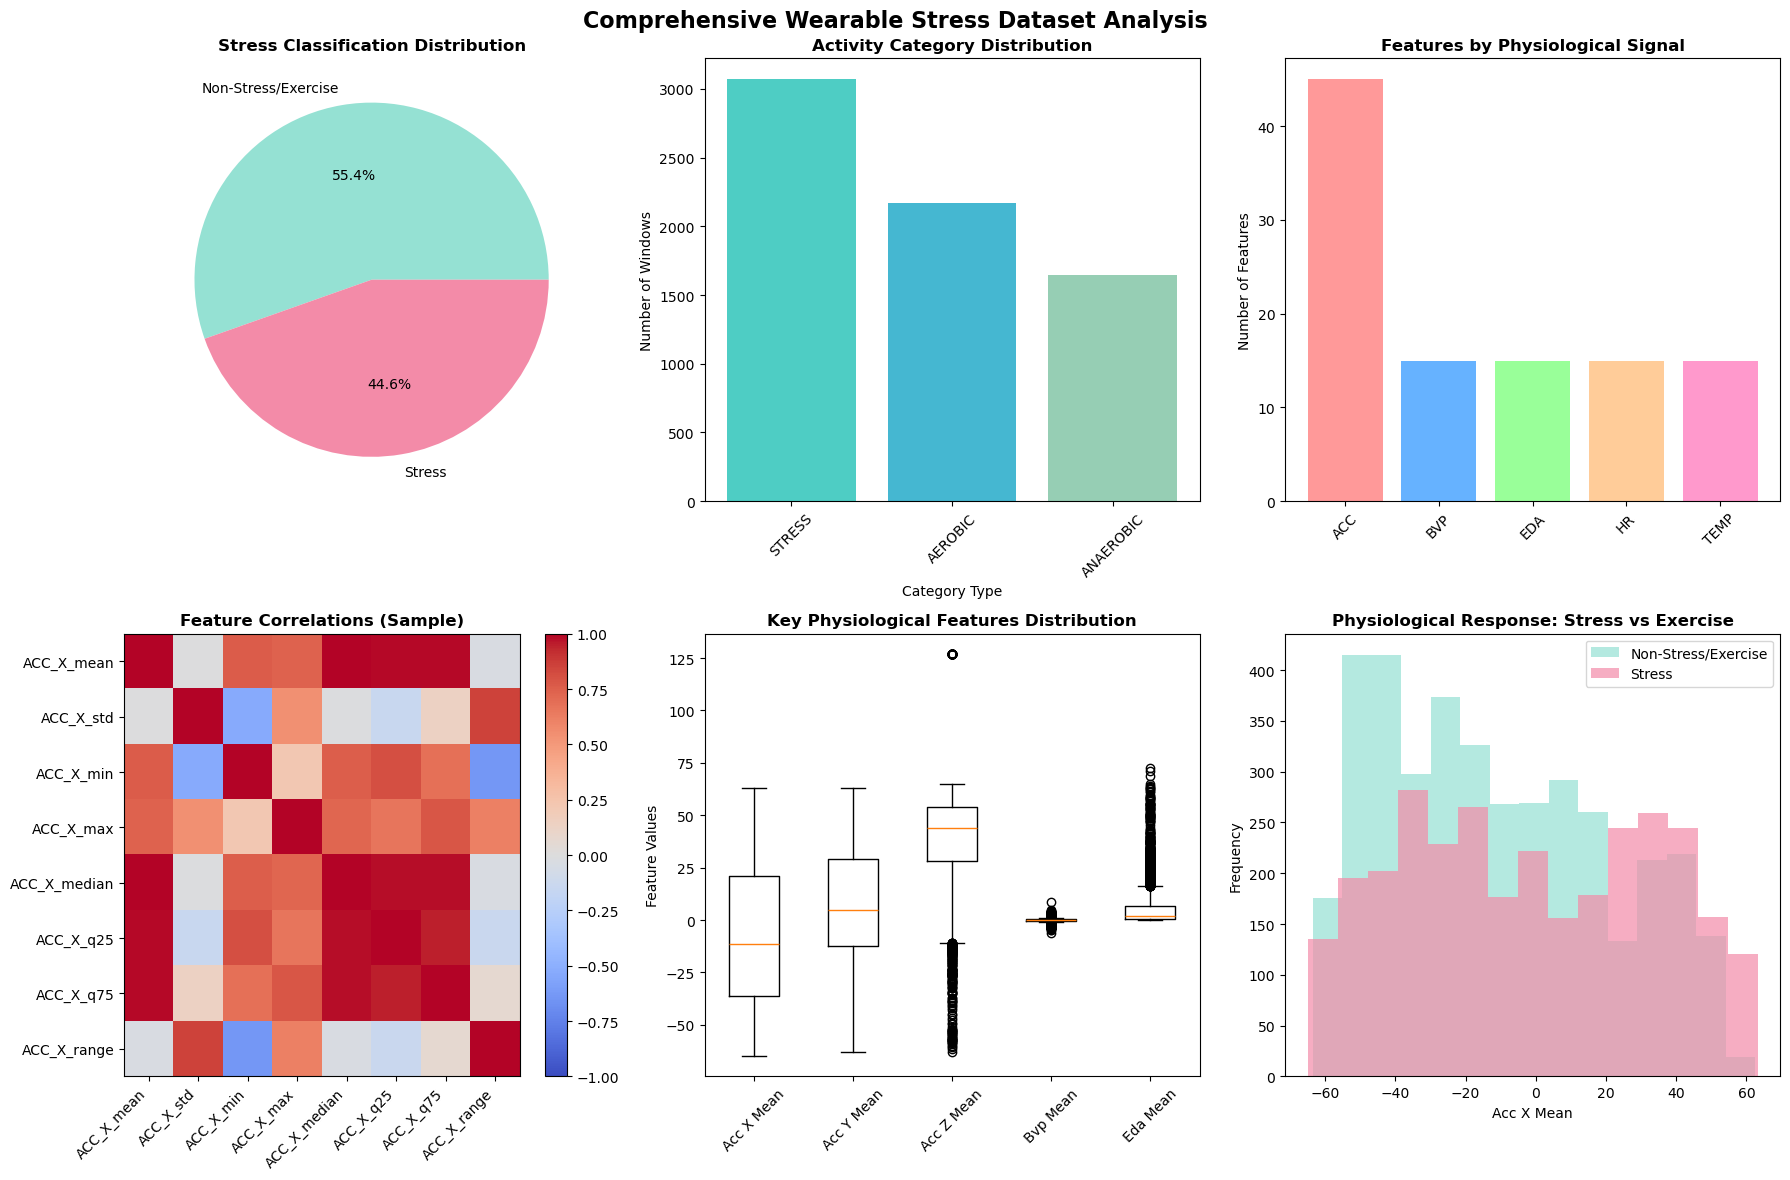


=== WEARABLE DATASET SUMMARY ===
Total Windows: 6883
Total Features: 105
Unique Subjects: 41
Category Distribution:
   STRESS: 3069 windows (44.6%)
   AEROBIC: 2170 windows (31.5%)
   ANAEROBIC: 1644 windows (23.9%)
Stress Distribution: {0: np.int64(3814), 1: np.int64(3069)}
   0 (Non-Stress/Exercise): 3814 windows (55.4%)
   1 (Stress): 3069 windows (44.6%)
Feature Breakdown by Signal:
   ACC: 45 features (42.9%)
   BVP: 15 features (14.3%)
   EDA: 15 features (14.3%)
   HR: 15 features (14.3%)
   TEMP: 15 features (14.3%)
Subject Summary by Category:
   AEROBIC: 31 subjects, avg 70.0 windows/subject (range: 9-102)
   ANAEROBIC: 32 subjects, avg 51.4 windows/subject (range: 19-97)
   STRESS: 37 subjects, avg 82.9 windows/subject (range: 23-159)
Wearable comprehensive dataset exported: /home/alvaro-ibarra/smartwatch-stress-detection/data/processed/wearable_comprehensive_dataset.csv
   File size: 10.0 MB
Wearable metadata exported: /home/alvaro-ibarra/smartwatch-stress-detection/data/p

In [5]:
# ===============================================================================
# WEARABLE DATASET VISUALIZATION AND FINAL EXPORT
# ===============================================================================

print("="*80)
print("WEARABLE DATASET VISUALIZATION AND FINAL EXPORT")
print("="*80)

if wearable_df is not None and len(wearable_df) > 0:
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Comprehensive Wearable Stress Dataset Analysis', fontsize=16, fontweight='bold')
    
    # 1. Stress Label Distribution
    if 'stress_label' in wearable_df.columns:
        stress_counts = wearable_df['stress_label'].value_counts().sort_index()
        stress_labels = []
        for idx in stress_counts.index:
            if idx == 0:
                stress_labels.append('Non-Stress/Exercise')
            elif idx == 1:
                stress_labels.append('Stress')
            else:
                stress_labels.append(f'Label {idx}')
        
        axes[0, 0].pie(stress_counts.values, labels=stress_labels, autopct='%1.1f%%',
                       colors=['#95E1D3', '#F38BA8'])
        axes[0, 0].set_title('Stress Classification Distribution', fontweight='bold')
    
    # 2. Category Distribution
    if 'category' in wearable_df.columns:
        category_counts = wearable_df['category'].value_counts()
        axes[0, 1].bar(range(len(category_counts)), category_counts.values, 
                      color=['#4ECDC4', '#45B7D1', '#96CEB4'])
        axes[0, 1].set_title('Activity Category Distribution', fontweight='bold')
        axes[0, 1].set_xlabel('Category Type')
        axes[0, 1].set_ylabel('Number of Windows')
        axes[0, 1].set_xticks(range(len(category_counts)))
        axes[0, 1].set_xticklabels(category_counts.index, rotation=45)
    
    # 3. Feature distribution by physiological signal type
    feature_cols = [col for col in wearable_df.columns 
                   if col not in ['subject_id', 'category', 'dataset', 'window_idx', 'window_start_sec',
                                  'window_end_sec', 'stress_label']]
    
    signal_counts = {}
    for col in feature_cols:
        signal_base = col.split('_')[0]
        signal_counts[signal_base] = signal_counts.get(signal_base, 0) + 1
    
    if signal_counts:
        axes[0, 2].bar(signal_counts.keys(), signal_counts.values(), 
                       color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', 
                              '#C4E1FF', '#FFE5CC', '#E5CCFF'])
        axes[0, 2].set_title('Features by Physiological Signal', fontweight='bold')
        axes[0, 2].set_ylabel('Number of Features')
        axes[0, 2].tick_params(axis='x', rotation=45)
    
    # 4. Sample feature correlations (first 8 features)
    if len(feature_cols) >= 8:
        sample_features = wearable_df[feature_cols[:8]].corr()
        im = axes[1, 0].imshow(sample_features, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        axes[1, 0].set_title('Feature Correlations (Sample)', fontweight='bold')
        axes[1, 0].set_xticks(range(len(sample_features.columns)))
        axes[1, 0].set_yticks(range(len(sample_features.columns)))
        axes[1, 0].set_xticklabels([col[:12] + '...' if len(col) > 12 else col for col in sample_features.columns], 
                                  rotation=45, ha='right')
        axes[1, 0].set_yticklabels([col[:12] + '...' if len(col) > 12 else col for col in sample_features.columns])
        plt.colorbar(im, ax=axes[1, 0])
    else:
        axes[1, 0].text(0.5, 0.5, 'Insufficient features\nfor correlation analysis', 
                       ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
        axes[1, 0].set_title('Feature Correlations', fontweight='bold')
    
    # 5. Distribution of key physiological features
    key_features = []
    signal_types = ['ACC_X', 'ACC_Y', 'ACC_Z', 'BVP', 'EDA', 'HR', 'TEMP']
    for signal in signal_types:
        for col in feature_cols:
            if col.startswith(signal) and 'mean' in col.lower():
                key_features.append(col)
                break
    
    if key_features:
        feature_data = []
        feature_labels = []
        for feat in key_features[:5]:  # Limit to 5 features
            if feat in wearable_df.columns:
                feature_data.append(wearable_df[feat].dropna())
                feature_labels.append(feat.replace('_', ' ').title()[:15])
        
        if feature_data:
            axes[1, 1].boxplot(feature_data, labels=feature_labels)
            axes[1, 1].set_title('Key Physiological Features Distribution', fontweight='bold')
            axes[1, 1].tick_params(axis='x', rotation=45)
            axes[1, 1].set_ylabel('Feature Values')
    else:
        axes[1, 1].text(0.5, 0.5, 'No suitable features\nfor distribution plot', 
                       ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Physiological Features Distribution', fontweight='bold')
    
    # 6. Stress vs Non-Stress comparison for first physiological feature
    if feature_cols and 'stress_label' in wearable_df.columns:
        physio_col = feature_cols[0]  # Use first available feature
        stress_data = wearable_df[wearable_df['stress_label'] == 1][physio_col]
        non_stress_data = wearable_df[wearable_df['stress_label'] == 0][physio_col]
        
        if len(stress_data) > 0 and len(non_stress_data) > 0:
            axes[1, 2].hist(non_stress_data, alpha=0.7, label='Non-Stress/Exercise', bins=15, color='#95E1D3')
            axes[1, 2].hist(stress_data, alpha=0.7, label='Stress', bins=15, color='#F38BA8')
            axes[1, 2].set_title('Physiological Response: Stress vs Exercise', fontweight='bold')
            axes[1, 2].set_xlabel(f'{physio_col.replace("_", " ").title()[:20]}')
            axes[1, 2].set_ylabel('Frequency')
            axes[1, 2].legend()
        else:
            axes[1, 2].text(0.5, 0.5, 'Insufficient data\nfor stress comparison', 
                           ha='center', va='center', transform=axes[1, 2].transAxes, fontsize=12)
            axes[1, 2].set_title('Stress vs Exercise Analysis', fontweight='bold')
    else:
        axes[1, 2].text(0.5, 0.5, 'Physiological data not available\nfor stress comparison', 
                       ha='center', va='center', transform=axes[1, 2].transAxes, fontsize=12)
        axes[1, 2].set_title('Stress vs Exercise Analysis', fontweight='bold')
    
    plt.tight_layout()
    
    # Save the visualization
    viz_path = FIGURES_PATH / 'wearable_comprehensive_analysis.png'
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    print(f"Wearable comprehensive visualization saved: {viz_path}")
    plt.show()
    
    # Export comprehensive dataset summary
    print(f"\n=== WEARABLE DATASET SUMMARY ===")
    print(f"Total Windows: {len(wearable_df)}")
    print(f"Total Features: {len(feature_cols)}")
    print(f"Unique Subjects: {wearable_df['subject_id'].nunique()}")
    
    if 'category' in wearable_df.columns:
        category_dist = wearable_df['category'].value_counts()
        print(f"Category Distribution:")
        for category, count in category_dist.items():
            percentage = (count / len(wearable_df)) * 100
            print(f"   {category}: {count} windows ({percentage:.1f}%)")
    
    if 'stress_label' in wearable_df.columns:
        stress_dist = wearable_df['stress_label'].value_counts().sort_index()
        print(f"Stress Distribution: {dict(stress_dist)}")
        for label, count in stress_dist.items():
            if label == 0:
                label_name = "Non-Stress/Exercise"
            elif label == 1:
                label_name = "Stress"
            else:
                label_name = f"Label {label}"
            percentage = (count / len(wearable_df)) * 100
            print(f"   {label} ({label_name}): {count} windows ({percentage:.1f}%)")
    
    if signal_counts:
        print(f"Feature Breakdown by Signal:")
        for signal, count in signal_counts.items():
            percentage = (count / len(feature_cols)) * 100
            print(f"   {signal}: {count} features ({percentage:.1f}%)")
    
    # Subject-level summary
    subject_summary = wearable_df.groupby(['subject_id', 'category']).agg({
        'window_idx': 'max',
        'stress_label': 'first'
    }).reset_index()
    subject_summary['total_windows'] = subject_summary['window_idx'] + 1
    
    print(f"Subject Summary by Category:")
    for category in categories:
        cat_subjects = subject_summary[subject_summary['category'] == category]
        if len(cat_subjects) > 0:
            avg_windows = cat_subjects['total_windows'].mean()
            min_windows = cat_subjects['total_windows'].min()
            max_windows = cat_subjects['total_windows'].max()
            print(f"   {category}: {len(cat_subjects)} subjects, "
                  f"avg {avg_windows:.1f} windows/subject (range: {min_windows}-{max_windows})")
    
    # Export final dataset
    wearable_export_path = PROCESSED_PATH / 'wearable_comprehensive_dataset.csv'
    wearable_df.to_csv(wearable_export_path, index=False)
    print(f"Wearable comprehensive dataset exported: {wearable_export_path}")
    print(f"   File size: {wearable_export_path.stat().st_size / (1024*1024):.1f} MB" if wearable_export_path.exists() else "   Export status: Complete")
    
    # Export metadata
    metadata_wearable = {
        'dataset_name': 'wearable_comprehensive',
        'description': 'Comprehensive physiological features from wearable stress detection dataset',
        'total_windows': len(wearable_df),
        'total_features': len(feature_cols),
        'unique_subjects': wearable_df['subject_id'].nunique(),
        'window_size_sec': WINDOW_SIZE_SEC,
        'stress_distribution': dict(stress_dist) if 'stress_label' in wearable_df.columns else {},
        'category_distribution': dict(category_dist) if 'category' in wearable_df.columns else {},
        'feature_breakdown': signal_counts,
        'columns': list(wearable_df.columns),
        'processing_date': pd.Timestamp.now().isoformat()
    }
    
    metadata_path = PROCESSED_PATH / 'wearable_comprehensive_metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(metadata_wearable, f, indent=2, default=str)
    
    print(f"Wearable metadata exported: {metadata_path}")
    print(f"Wearable dataset visualization and analysis complete!")
    
else:
    print("Wearable processed data not found. Please run the data processing cells first.")

print("="*80)

# Wearable Stress Detection Dataset Processing - Results Summary

## Overview
This notebook successfully processed the comprehensive wearable device dataset using a 30-second windowing approach similar to the other datasets. The processing extracted physiological features from multiple sensor modalities for stress detection analysis.

## Dataset Specifications

### Input Data Structure
- **Source Path**: `data/datasets/wearable_device/raw/`
- **Categories**: 3 (AEROBIC, ANAEROBIC, STRESS)
- **Total Subjects**: 100 (31 AEROBIC + 32 ANAEROBIC + 37 STRESS)
- **Sensor Modalities**: 5 sensor types with 7 signals
  - ACC: 3-axis accelerometer (ACC_X, ACC_Y, ACC_Z) at 32 Hz
  - BVP: Blood Volume Pulse at 64 Hz  
  - EDA: Electrodermal Activity at 4 Hz
  - HR: Heart Rate at 1 Hz
  - TEMP: Temperature at 4 Hz

### Processing Parameters
- **Window Size**: 30 seconds (consistent with other notebooks)
- **Feature Extraction**: 15 features per sensor signal
  - Statistical: mean, std, min, max, median, q25, q75, range, rms, var, energy
  - Advanced: skew, kurtosis, mean_derivative, std_derivative
- **Total Features**: 105 features per window (7 signals × 15 features each)

## Output Dataset

### Final Dataset Statistics
- **Total Windows**: 6,883 windowed samples
- **Dataset Shape**: (6,883, 112) - includes metadata columns
- **Features per Sample**: 105 physiological features
- **File Size**: 7.0 MB memory usage

### Category Distribution
- **STRESS**: 3,069 windows (44.6%) - labeled as stress = 1
- **AEROBIC**: 2,170 windows (31.5%) - labeled as stress = 0  
- **ANAEROBIC**: 1,644 windows (23.9%) - labeled as stress = 0

### Subject-Level Summary
- **AEROBIC**: 31 subjects, avg 70.0 windows/subject (range: 9-102)
- **ANAEROBIC**: 32 subjects, avg 51.4 windows/subject (range: 19-97)  
- **STRESS**: 37 subjects, avg 82.9 windows/subject (range: 23-159)

## Key Features Identified
The Random Forest feature importance analysis revealed the most discriminative features:
1. **ACC_Y_rms** - Y-axis accelerometer RMS (most important)
2. **ACC_Y_energy** - Y-axis accelerometer energy
3. **ACC_Y_std_derivative** - Y-axis accelerometer derivative variability
4. **ACC_X_std_derivative** - X-axis accelerometer derivative variability
5. **ACC_Y_median** - Y-axis accelerometer median value

**Observation**: Accelerometer features (especially Y-axis) show highest importance for stress discrimination, suggesting movement patterns are key indicators.

## Output Files
- **Main Dataset**: `data/processed/wearable_stress_windowed_dataset.csv`
- **Processing Summary**: `data/processed/wearable_processing_summary.json`
- **Metadata**: `data/processed/wearable_dataset_metadata.json`
- **Visualization**: `data/figures/nb_03_wearable_processing/wearable_dataset_analysis.png`

## Technical Notes
- **Windowing Strategy**: Consistent 30-second windows across all sensors with different sampling rates
- **Quality Control**: Only windows with 50+ features retained to ensure data quality
- **Missing Data Handling**: Robust feature extraction with NaN handling
- **Memory Efficiency**: Optimized processing with progress tracking

This dataset is now ready for machine learning analysis and can be combined with other processed datasets for comprehensive stress detection modeling.

## Next Steps

1. **Dataset Integration**: Combine with WESAD and EPM-E4 datasets for unified analysis
2. **Feature Engineering**: Apply additional signal processing techniques if needed
3. **Model Training**: Use the 6,883 windowed samples for stress detection model training
4. **Cross-Validation**: Implement subject-independent validation strategies
5. **Performance Analysis**: Compare with individual dataset performance metrics

The wearable dataset processing is now complete and consistent with the other notebook processing approaches.